# SPAHR MODEL WITH MESA

Links

* https://github.com/projectmesa/mesa/blob/master/examples/virus_on_network/virus_on_network/model.py
* https://networkx.github.io/documentation/stable/reference/drawing.html
* https://stackoverflow.com/questions/63681056/visualizing-agents-using-mesa-networkx

## IMPORTS

In [50]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx

from collections import Counter

In [24]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [25]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    PRESCRIBED = 1
    ADDICTION = 2
    HEROIN_AD = 3
    RECOVERED = 4
    REMOVED = 5
    

## Reattachment Methods

In [26]:
### Currently used in SPAHR implementation
def er_reattach(G, node, p):
    '''Given the model graph G, the node id node, and the graph density p:
    removes node from G and reattaches it to nodes in G using probability p'''
    G.remove_node(node) # remove existing node and connections
    
    successes = np.random.binomial(len(G.nodes), p, 1)[0] # draw a number edges from the binomial distribution
    if successes == 0: # Guarantee a connection
        successes = 1
    new_neighbors = np.random.choice(G.nodes, size=successes, replace = False)

    G.add_node(node) # re-introduce node

    for neighbor in new_neighbors:
        G.add_edge(neighbor, node)

# not tested but could be cool
def pref_attach(G, node, p, alpha):
    '''This model removes node from G and reattaches it to some nodes using random sampleing and prefferential attatchment'''
    G.remove_node(node) # remove existing node and connections
    
    successes = np.random.binomial(len(G.nodes), p, 1)[0] # draw a number edges from the binomial distribution
    if successes == 0: #Gaurentee a connection
        successes = 1
    

    alpha_successes = np.random.binomial(len(successes), alpha, 1)[0] # draw the number of successes that should use the prefferential attatchment method
    successes -= alpha_successes
    G.add_node(node) # re-introduce node
    new_neighbors = np.random.choice(G.nodes, size=successes, replace = False) # draw the uniformly sampled neighbors
    if alpha_successes > 0:
        degrees = G.degree
        deg_seq = np.array([deg[1] * int(not(deg[0] in new_neighbors)) for deg in degrees])
        degree_weights = deg_seq / deg_seq.sum()
        new_pref_neighbors = np.random.choice(np.arange(len(degrees)), p = degree_weights, size = alpha_successes)

    new_neighbors = list(new_neighbors) + list(new_pref_neighbors)

    for neighbor in new_neighbors:
        G.add_edge(neighbor, node)

# Old implementation of a faulty preferrential attatchment model
# def pref_attach(G, node, alpha):
#     # reintroduce using preferrential attachment method
#     G.remove_node(node)
#     degrees = nx.degree(G)

#     # determine u using one of two mechanisms
    
#     if np.random.rand() < alpha: 
#         deg_seq = np.array([deg[1] for deg in degrees])
#         degree_weights = deg_seq / deg_seq.sum()
#         u = np.random.choice(np.arange(len(degrees)), p = degree_weights)
#     else:
#         u = np.random.choice(np.arange(len(degrees)))
#     # integer index of new node v
#     G.add_node(node)
#     # add new edge to graph    
#     G.add_edge(u, node)


## SPAHR Agent

In [27]:
def relapse(g1, g2, sigma, w):
    if g1 == 0 and g2 == 0:
        return sigma/2
    return sigma * g1 / (g1 + g2 + w)

class SPAHRAgent(Agent): 
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = State.SUSCEPTIBLE

    def step(self):
        '''Method to update the state of a given node'''
        # neighbors of every node
        if self.state == State.REMOVED:
            # Remove existing node from graph
            self.model.deaths += 1
            er_reattach(self.model.G, self.pos, self.model.p)
            #a = SPAHRAgent(i+1, self)
            self.state = State.SUSCEPTIBLE
            self.model.counts[State.SUSCEPTIBLE] += 1
            self.model.G.nodes[self.pos]["agent"] = []
            return
            

        neighbors_nodes = self.model.grid.get_neighbors(self.pos, 
                                                include_center = False)
        
        varsSol = self.transitionVars(neighbors_nodes)
        sols = np.array(list(varsSol.values())) # each transtion variables calculations
        lam = np.sum(sols) # the total of all the transition variables calculations
        tr_probs = sols / lam  # each variables contribution normalized by lambda
        p_transition = 1 - math.e ** (-lam * self.model.tstep) # probability of transition

        # transition occurs
        if np.random.rand() < p_transition: 
            choice = np.random.choice(list(varsSol.keys()), p = tr_probs) # choose which group to transition to based on transition probabilities

            self.model.counts[self.state] -= 1
            self.state = choice.destination # make choice new destination
            self.model.counts[self.state] += 1
        
        if self.state == State.REMOVED: # if moved to the removed category then run re_attachment
            self.step()


    def transitionVars(self, neighbor_list):
        '''given list of neighbors returns a dictionary with entries transition_var : calculated contribution to Lambda'''
        k = len(neighbor_list) * 1.0
        
        neighbor_counts = dict(Counter([agent.state for agent in neighbor_list]))

        neighbor_densities = {State(state): 0 for state in range(6)} # start with every neighbor presents = 0

        for state in neighbor_counts.keys(): # calculate existing neighbor densities
            neighbor_densities[state] = neighbor_counts[state] / k

        global_densities = {State(state): self.model.counts[state] / (self.model.n - 1) for state in range(6)} # needed in some cases where no neighbors exist
        possible = self.model.transitions[self.state] # possible transitions from current state
        varsSol = {tvr: tvr.func(neighbor_densities, global_densities) for tvr in possible}

        return varsSol

        
    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)

In [28]:
import random

## SPAHR model class

In [29]:
default_data = {"random_starts": False, "n": 2000, "drate": 0.0071, "tstep": 0.01, "od_rateA": 0.00883, "od_rateH": 0.0466, "S2P": 0.27, "P2S": 2.53, "S2H": 0.222, "S2A_A": 0.000878, "S2A_P": 0.0000654, "P2A": 0.00505, "P2H": 0.236, "A2H": 19.7, "A2R":  0.198, "H2R": 0.000531, "sigma": 0.102, "omega": 0.0001, "S0": 0.892365, "P0": 0.095, "A0": 0.0071, "H0": 0.000465, "R0": 0.00507}

class trVar(Model):
    """A class for transion variables"""

    def __init__(self, value, destination, linear = True, func = None):
        self.value = value
        self.destination = destination
        self.linear = linear

        # create a function to get the variables contribution to lambda
        if linear:
            # linear function just returns its value
            self.func = lambda ldata, gdata: self.value

        else:
            if func == None:
                # standard non-linear function that mutliplies its value by the density of neighbors in the destination group
                self.func = lambda ldata, gdata: ldata[destination] * self.value 
            else:
                # the last case is if we have created a custom function for this calculation
                self.func = func

class SPAHRModel(Model):
    """A model for infection spread."""
    
    def __init__(self, G, data = default_data):

        # The network x network
        #self.random = random # ****if you get a self.random error uncomment this line****
        self.G = G
        
        self.grid = NetworkGrid(self.G)
        
        # Basic Params:
        self.n = G.number_of_nodes()
        self.tstep = data["tstep"] # timestep
        self.alpha = 3/5 # used in preferential re-attachment
        m = G.number_of_edges()
        self.p = 2*m / (self.n * (self.n - 1)) # calculates the density of the given graph used for node reconnnection
        self.deaths = 0

        # The list of rate variables we may need (comments are the variable names in the paper)
        # _______________________Transition Variables______________________________
        # Linear Transition variables:
        self.drate = trVar(data["drate"], State.REMOVED)        # µ
        self.od_rateA = trVar(data["od_rateA"], State.REMOVED)  # µ_A
        self.od_rateH = trVar(data["od_rateH"], State.REMOVED)  # µ_H
        self.S2P = trVar(data["S2P"], State.PRESCRIBED)         # alpha
        self.P2S = trVar(data["P2S"], State.SUSCEPTIBLE)        # epsilon
        self.P2A = trVar(data["P2A"], State.ADDICTION)          # Gamma
        self.A2R = trVar(data["A2R"] , State.RECOVERED)         # Zeta
        self.H2R = trVar(data["H2R"], State.RECOVERED)          # v
        # self.R2A = trVar(data["sigma"], State.ADDICTION)        # sigma for R2A transition
        # self.R2H = trVar(data["sigma"], State.HEROIN_AD)        # sigma for R2H transition

        # Non-Linear Transition variables:
        self.S2H = trVar(data["S2H"] , State.HEROIN_AD, linear=False)      # Theta_1
        self.S2A_A = trVar(data["S2A_A"], State.ADDICTION, linear=False)   # Beta_A
        self.P2H = trVar(data["P2H"], State.HEROIN_AD, linear=False)       # Theta_2
        self.A2H = trVar(data["A2H"], State.HEROIN_AD, linear=False)       # Theta_3

        # other transition variables (special cases)
        self.S2A_P = trVar(data["S2A_P"], State.ADDICTION, linear = False, func = lambda ldata, gdata: ldata[State.PRESCRIBED] * data["S2A_A"])        # Beta_p
        self.R2A = trVar(data["sigma"], State.ADDICTION, linear=False, func = lambda ldata, gdata: relapse(gdata[State.ADDICTION], gdata[State.HEROIN_AD], data["sigma"], data["omega"]))        # sigma for R2A transition
        self.R2H = trVar(data["sigma"], State.HEROIN_AD, linear=False,func = lambda ldata, gdata: relapse(gdata[State.HEROIN_AD], gdata[State.ADDICTION], data["sigma"], data["omega"]))        # sigma for R2H transition
        #_________________________________________________________________________________

        # Starting population distribution
        self.S0 = data["S0"]
        self.P0 = data["P0"]
        self.A0 = data["A0"]
        self.H0 = data["H0"]
        self.R0 = data["R0"]
        self.proportions = [self.S0, self.P0, self.A0, self.H0, self.R0, 0]
        
        # each state stores its outward transition variables
        self.transitions = {
            State.SUSCEPTIBLE: [self.drate, self.S2A_A, self.S2A_P, self.S2H, self.S2P],
            State.PRESCRIBED:  [self.drate, self.P2A, self.P2H, self.P2S],
            State.ADDICTION:   [self.drate, self.od_rateA, self.A2H, self.A2R],
            State.HEROIN_AD:   [self.drate, self.od_rateH, self.H2R],
            State.RECOVERED:   [self.drate, self.R2A, self.R2H],
            State.REMOVED:     [] # removed should have its own case (fancy new node addition thing)
        }
        
        self.schedule = RandomActivation(self)
        self.running = True
        self.counts = {State(i): 0 for i in range(6)}
        
        # Create agents
        if data["random_starts"] == True:
            for i, node in enumerate(self.G.nodes()):
                a = SPAHRAgent(i+1, self)
                self.schedule.add(a)
                #add agent
                self.grid.place_agent(a, node)

                #make some agents infected at start # _________________HOW DO THEY INITIALIZE IN PAPER?______________
                initial_state = np.random.choice([0,1,2,3,4,5], p=self.proportions)
                a.state = State(initial_state)
                self.counts[a.state] += 1
        else:
            populations = [int(prop * self.n) for prop in self.proportions] # get the actual starting populations of each category
            populations[0] += self.n - sum(populations) # add the potential remainder to suseptible group
            node_list = list(self.G.nodes).copy()
            shuffled_nodes = random.shuffle(node_list)
            group = 0
            for i, node in enumerate(node_list):
                a = SPAHRAgent(i+1, self)
                self.schedule.add(a)
                #add agent
                self.grid.place_agent(a, node)

                if populations[group] == 0:
                    group += 1 # if current group population empty move to next
                
                populations[group] -= 1

                a.state = State(group)
                self.counts[a.state] += 1
        
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
        
        print("Groupings: ", self.counts)
         
    
    # def get_recovery_time(self):
    #     return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        if self.counts[State.HEROIN_AD] == 0:
            while(True):
                a = np.random.choice(list(self.schedule._agents))
                if a.state == State.SUSCEPTIBLE:
                    a.state = State.HEROIN_AD
                    self.counts[State.SUSCEPTIBLE] -= 1
                    self.counts[State.HEROIN_AD] += 1
                    break
                
        self.datacollector.collect(self)
        # print(len(self.schedule._agents)) # schedule is not empty
        self.schedule.step()

# Model Exploration and Associated Functions

In [30]:
G = nx.erdos_renyi_graph(50, 3/(50-1))
model = SPAHRModel(G)
model.step()
model

Groupings:  {<State.SUSCEPTIBLE: 0>: 46, <State.PRESCRIBED: 1>: 4, <State.ADDICTION: 2>: 0, <State.HEROIN_AD: 3>: 0, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


In [31]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Perscribed','Addicted', 'Heroin Addict', 'Rehab', 'Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f

def get_steady_state(model, n):
    """
    returns the steady state values for our five categories based on the last n steps
    """
    data = get_column_data(model)[-n:]
    means = data.mean().to_numpy()
    sems = data.sem().to_numpy()
    
    return (means, sems)


## Erdos Renyi Graph Exploration

In [32]:
# Warning This Cell is a time Commitment (rn abt 4 min)
G = nx.erdos_renyi_graph(n = 2000, p = 0.01)
model = SPAHRModel(G)
steps = 5000
st = time.time()
for i in range(steps):
    if i % 500 == 0:
        print(i+1)
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()


Groupings:  {<State.SUSCEPTIBLE: 0>: 1786, <State.PRESCRIBED: 1>: 190, <State.ADDICTION: 2>: 14, <State.HEROIN_AD: 3>: 10, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
1
501
1001
1501
2001
2501
3001
3501
4001
4501
3718.186156988144


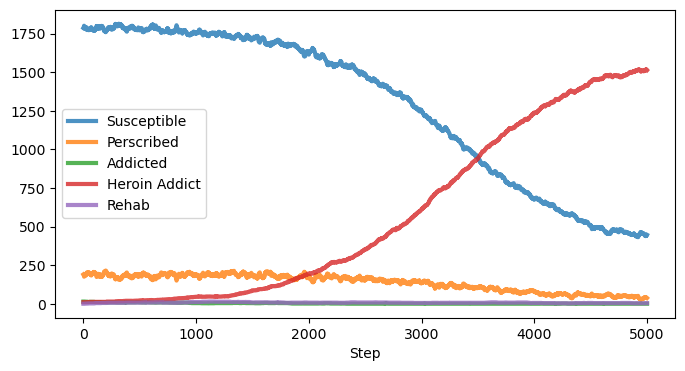

In [33]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

## Get varying values

idea: for every combination of starting conditions return the proprtion of H+A steady state.

In [ ]:
# structure inputs as follows
input_data = [(State.ADDICTION, [.03, .06, .09, .12, .15]), (State.PRESCRIBED, [.15, .18, .21, .24, .27])]

start_names = ["S0", "P0", "A0", "H0", "R0"] # used in below functions
state_map = {State(i): start_names[i] for i in range(len(start_names))} # map states to their respective starting population variables

def rebalance(edited, existing):
    '''given edited proportions and the existing proportions,
    properly scales the existing proportions so the total sum remains 1'''
    return existing * (1 - np.sum(edited))/np.sum(existing)

def run_steady_states(edited_tuple, name_order, existing, model_data, G, steps, n, count):
    '''Runs a model on network G updating model_data according to new starting populations'''

    reweighted = rebalance(np.array(edited_tuple), existing) # reweight populations to add to 1
    params = list(edited_tuple) + list(reweighted)

    for i in range(len(name_order)): # add these populations to the model_data
        model_data[name_order[i]] = params[i]

    count[0] += 1
    print(f"Running model {count[0]} with params: ", {state: model_data[state] for state in start_names})
    model = SPAHRModel(G)

    for i in range(steps):
        if i % 500 == 0:
            print(f"Model {count[0]} completed {i} steps")
        model.step()
    #print(f"Model {count[0]} complete \n")
    ss = get_steady_state(model, n)
    return ss[0]


def vary_values(G, start_data, model_data, steps = 5000, n = 100):
    '''takes in a list (size 2) start_data with tuple entries (STATE, [starting proportions ...])'''
    
    combinations = np.array([[(S1_0, S2_0) for S2_0 in start_data[1][1]] for S1_0 in start_data[0][1]])
    group1, group2 = [state_map[state[0]] for state in start_data] # get the states we are modifying
    other_groups = {name: model_data[name] for name in start_names if name != group1 and name != group2}
    name_order = [group1, group2] + list(other_groups.keys())
    existing = np.array(list(other_groups.values()))

    count = {0:0} # counter for checking which model is running (a dictionary so it can be passed by reference)

    #print(f"Calculating steady states for {len(start_data[0][1] * len(start_data[1][1]))} models")
    #print(f"Calculating for the following values of {(group1, group2)}:")
    #print(np.apply_along_axis(lambda x: f"({x[0]}, {x[1]})", axis = 2, arr = combinations))
    gcount = count

    return np.apply_along_axis(lambda x: run_steady_states(x, name_order, existing, model_data, G.copy(), steps, n, count), axis = 2, arr = combinations) # plan run the combinations matrix through our special function


In [59]:
# TOOK 11.25 minutes with ER(n = 500, p = 0.05), steps = 2000, 5x5 starting conditions
G = nx.erdos_renyi_graph(500, p = 0.05)
input_data = [(State.ADDICTION, [.03, .06, .09]), (State.PRESCRIBED, [.15, .18, .21])]
output = vary_values(G, input_data, default_data.copy(), steps = 1000, n = 30)
output

Calculating steady states for 9 models
Calculating for the following values of ('A0', 'P0'):
[['(0.03, 0.15)' '(0.03, 0.18)' '(0.03, 0.21)']
 ['(0.06, 0.15)' '(0.06, 0.18)' '(0.06, 0.21)']
 ['(0.09, 0.15)' '(0.09, 0.18)' '(0.09, 0.21)']]
Running model 1 with params:  {'S0': 0.814945205479452, 'P0': 0.15, 'A0': 0.03, 'H0': 0.00042465753424657536, 'R0': 0.00463013698630137}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 1 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 1 completed 500 steps
Model 1 complete 

Running model 2 with params:  {'S0': 0.7851301369863014, 'P0': 0.18, 'A0': 0.03, 'H0': 0.00040912128299365187, 'R0': 0.004460741730704978}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 2 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 2 completed 500 steps
Model 2 complete 

Running model 3 with params:  {'S0': 0.7553150684931506, 'P0': 0.21, 'A0': 0.03, 'H0': 0.0003935850317407284, 'R0': 0.004291346475108587}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 3 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 3 completed 500 steps
Model 3 complete 

Running model 4 with params:  {'S0': 0.7851301369863014, 'P0': 0.15, 'A0': 0.06, 'H0': 0.00040912128299365187, 'R0': 0.004460741730704978}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 4 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 4 completed 500 steps
Model 4 complete 

Running model 5 with params:  {'S0': 0.7553150684931506, 'P0': 0.18, 'A0': 0.06, 'H0': 0.0003935850317407284, 'R0': 0.004291346475108587}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 5 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 5 completed 500 steps
Model 5 complete 

Running model 6 with params:  {'S0': 0.7254999999999999, 'P0': 0.21, 'A0': 0.06, 'H0': 0.0003780487804878049, 'R0': 0.0041219512195121944}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 6 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 6 completed 500 steps
Model 6 complete 

Running model 7 with params:  {'S0': 0.7553150684931506, 'P0': 0.15, 'A0': 0.09, 'H0': 0.0003935850317407284, 'R0': 0.004291346475108587}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 7 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 7 completed 500 steps
Model 7 complete 

Running model 8 with params:  {'S0': 0.7254999999999999, 'P0': 0.18, 'A0': 0.09, 'H0': 0.0003780487804878049, 'R0': 0.0041219512195121944}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 8 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 8 completed 500 steps
Model 8 complete 

Running model 9 with params:  {'S0': 0.6956849315068492, 'P0': 0.21, 'A0': 0.09, 'H0': 0.0003625125292348814, 'R0': 0.003952555963915803}
Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
Model 9 completed 0 steps


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Model 9 completed 500 steps
Model 9 complete 



array([[[415.06666667,  54.06666667,   0.        ,  27.86666667,
           3.        ],
        [428.86666667,  45.        ,   0.83333333,  25.3       ,
           0.        ],
        [437.26666667,  46.43333333,   0.        ,  14.3       ,
           2.        ]],

       [[425.03333333,  45.53333333,   0.        ,  26.9       ,
           2.53333333],
        [444.13333333,  47.86666667,   2.        ,   5.        ,
           1.        ],
        [436.73333333,  53.83333333,   2.        ,   5.43333333,
           2.        ]],

       [[433.26666667,  47.66666667,   1.        ,  17.06666667,
           1.        ],
        [439.73333333,  40.13333333,   2.7       ,  14.13333333,
           3.3       ],
        [434.86666667,  51.93333333,   0.        ,  12.2       ,
           1.        ]]])

In [37]:
def get_AH_proportions(output, G):
    proportions = output * (G.number_of_nodes() ** -1)
    return proportions[:,:,2:4]#cut out A and H groups from the poportions 

[[[0.         0.05573333]
  [0.00166667 0.0506    ]
  [0.         0.0286    ]]

 [[0.         0.0538    ]
  [0.004      0.01      ]
  [0.004      0.01086667]]

 [[0.002      0.03413333]
  [0.0054     0.02826667]
  [0.         0.0244    ]]]
[[0.03613333 0.03366667 0.0244    ]
 [0.0538     0.014      0.01486667]
 [0.05573333 0.05226667 0.0286    ]]


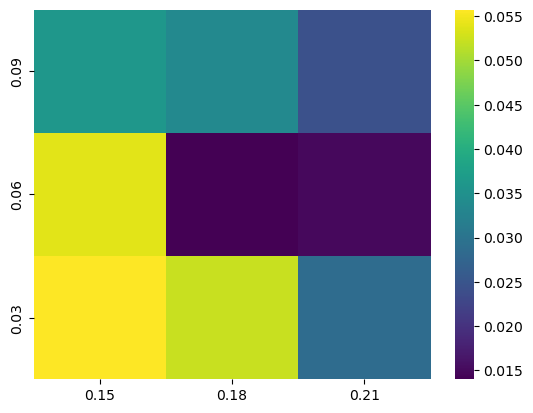

In [65]:
propAH = get_AH_proportions(output, G)

print(propAH)


#
final_proportion = np.zeros([3,3])

for i in range(len(propAH)):
    for j in range(len(propAH[0])):
        final_proportion[i,j] = propAH[i][j][0] + propAH[i][j][1]

final_proportion = final_proportion[::-1,:]

sns.heatmap(final_proportion, xticklabels=[.15, .18, .21], yticklabels=[.03, .06, .09][::-1], cmap="viridis")
print(final_proportion)
plt.show()

#input_data = [(State.ADDICTION, [.03, .06, .09, .12, .15]), (State.PRESCRIBED, [.15, .18, .21, .24, .27])]

In [39]:
start_data = [[1,2,3,4,5], [5,4,3,2,1]]
combinations = np.array([[(S1_0, S2_0) for S2_0 in start_data[1]] for S1_0 in start_data[0]])
# combinations[0,0,:] # working as expected
np.apply_along_axis(lambda x: f"({x[0]}, {x[1]})", axis = 2, arr = combinations)

array([['(1, 5)', '(1, 4)', '(1, 3)', '(1, 2)', '(1, 1)'],
       ['(2, 5)', '(2, 4)', '(2, 3)', '(2, 2)', '(2, 1)'],
       ['(3, 5)', '(3, 4)', '(3, 3)', '(3, 2)', '(3, 1)'],
       ['(4, 5)', '(4, 4)', '(4, 3)', '(4, 2)', '(4, 1)'],
       ['(5, 5)', '(5, 4)', '(5, 3)', '(5, 2)', '(5, 1)']], dtype='<U6')

In [40]:
def add5(i):
    return i + 5

a = np.array([1,2,3,4,5])
add5(a)

array([ 6,  7,  8,  9, 10])

In [41]:
existing = np.array([0.2, 0.2, 0.2])
edited = np.array([0.1, 0.2])
scaled_existing = rebalance(edited, existing)
print(list(edited) + list(scaled_existing))
print(sum(list(edited) + list(scaled_existing)))


[0.1, 0.2, 0.23333333333333328, 0.23333333333333328, 0.23333333333333328]
0.9999999999999999


## Detect steady state
Go back through data to find where the populations diverge from 2% (check us on this) of the steady state value.

In [42]:
model.deaths

1991

SOMETHING SEEMS WRONG (Still relavent might need to mess with the conversion rates between groups for our models), <br>
The addiction and herion groups stay suspitiously low

Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


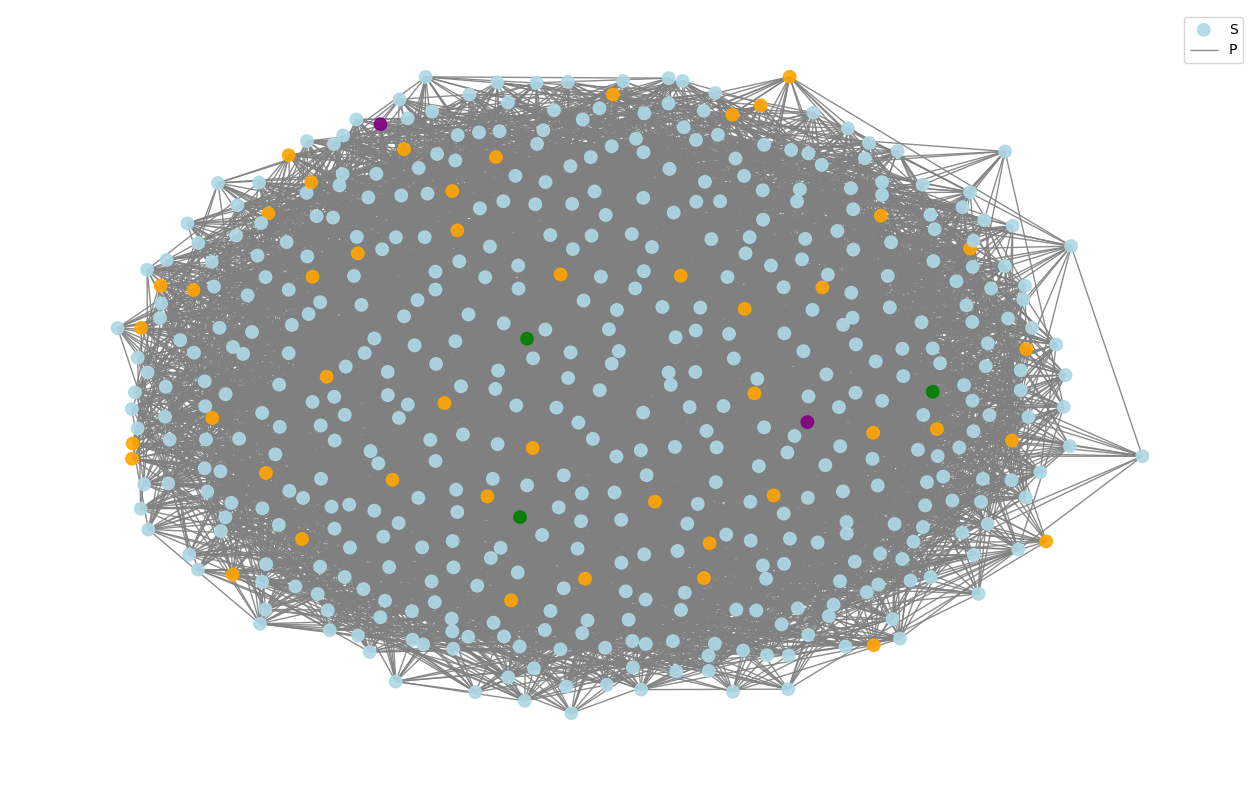

In [43]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["lightblue", "orange", "green", "purple", "pink", "yellow"])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':
        pos = nx.kamada_kawai_layout(graph)
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    #cells = [(i.pos,int(i.state)) for i in model.grid.get_all_cell_contents()]
    #print (cells[:10])
    #print (pos)
    #print (pd.Series(states).value_counts())
    colors = [cmap(i) for i in states]
    
    nx.draw(graph, pos, node_size=80, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    #print (ax.patches)
    #ax.legend(['S','I','R'])
    ax.legend(['S', 'P', 'A', 'H', 'R'])
    ax.set_title(title)
    return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = SPAHRModel(G)
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')

Attempt with equal starting populations

In [44]:
G = nx.erdos_renyi_graph(n = 500, p = 3/(500-1))
mydata = default_data.copy()
mydata["S0"], mydata["P0"], mydata["A0"], mydata["H0"], mydata["R0"] = (0.2, 0.2, 0.2, 0.2, 0.2)
model = SPAHRModel(G, data=mydata)
steps = 50
st = time.time()

for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:10])

/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Groupings:  {<State.SUSCEPTIBLE: 0>: 100, <State.PRESCRIBED: 1>: 100, <State.ADDICTION: 2>: 100, <State.HEROIN_AD: 3>: 100, <State.RECOVERED: 4>: 100, <State.REMOVED: 5>: 0}
0.3307979106903076
      Susceptible  Perscribed  Addicted  Heroin Addict  Rehab
Step                                                         
0             100         100       100            100    100
1              98         102        99            101    100
2              97         103        93            107    100
3              96         104        89            111    100
4              99         101        87            113    100
5             101          99        85            115    100
6             105          95        80            120    100
7             107          93        77            123    100
8             109          91        75            125    100
9             114          87        72            127    100


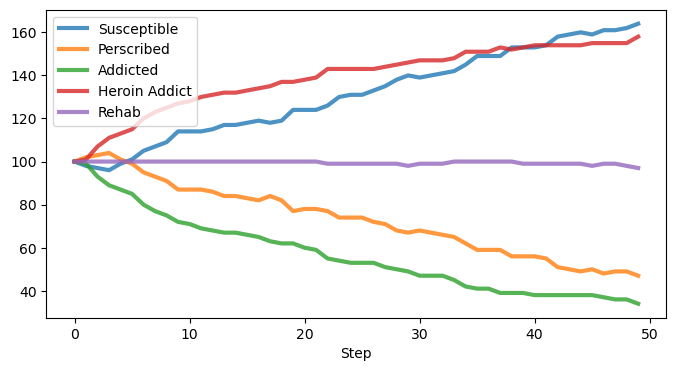

In [45]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

Groupings:  {<State.SUSCEPTIBLE: 0>: 448, <State.PRESCRIBED: 1>: 47, <State.ADDICTION: 2>: 3, <State.HEROIN_AD: 3>: 2, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}


/Users/charlie/anaconda3/envs/spahr-env/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


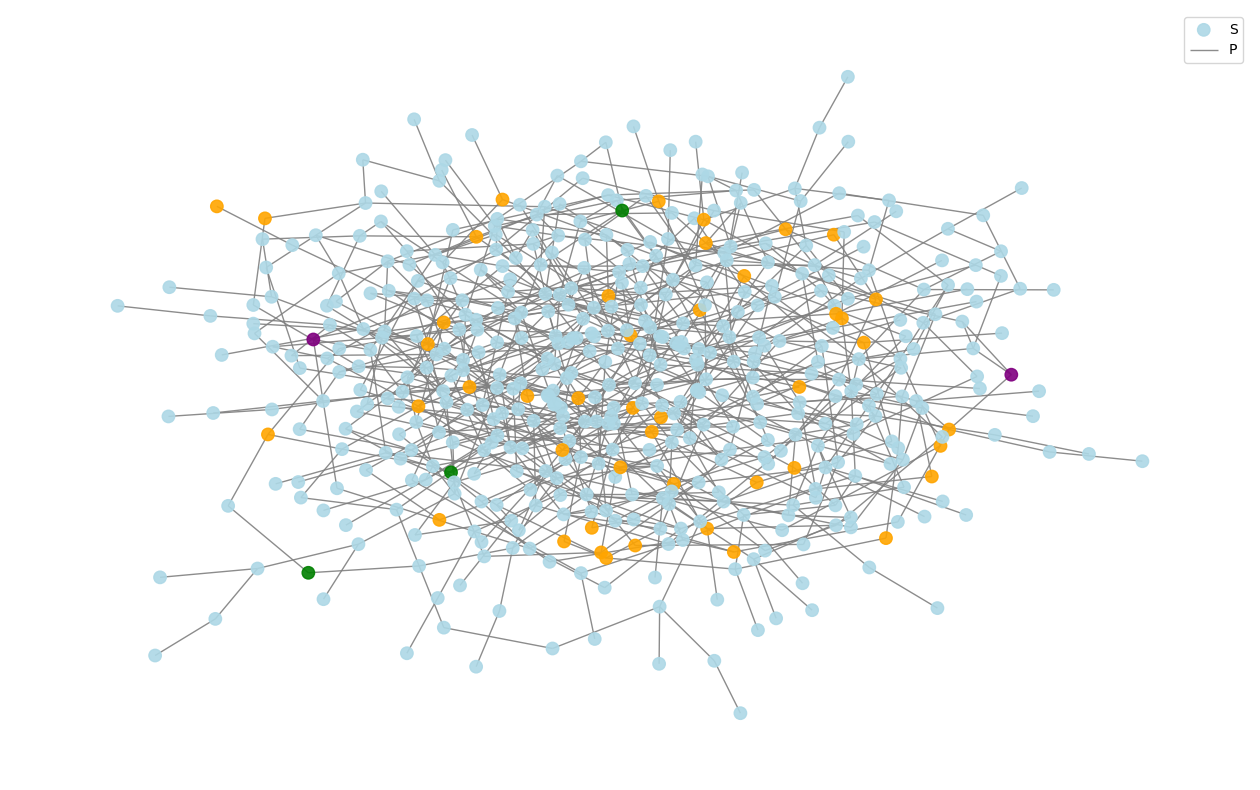

In [46]:
fig,ax=plt.subplots(1,1,figsize=(16,10))
model = SPAHRModel(G)
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')

In [47]:
model.deaths

0

In [48]:
default_data

{'random_starts': False,
 'n': 2000,
 'drate': 0.0071,
 'tstep': 0.01,
 'od_rateA': 0.00883,
 'od_rateH': 0.0466,
 'S2P': 0.27,
 'P2S': 2.53,
 'S2H': 0.222,
 'S2A_A': 0.000878,
 'S2A_P': 6.54e-05,
 'P2A': 0.00505,
 'P2H': 0.236,
 'A2H': 19.7,
 'A2R': 0.198,
 'H2R': 0.000531,
 'sigma': 0.102,
 'omega': 0.0001,
 'S0': 0.892365,
 'P0': 0.095,
 'A0': 0.0071,
 'H0': 0.000465,
 'R0': 0.00507}

In [49]:
%pip list numpy

Package                   Version
------------------------- --------------
anyio                     4.7.0
appnope                   0.1.2
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
backcall                  0.2.0
beautifulsoup4            4.12.3
binaryornot               0.4.4
bleach                    6.2.0
bokeh                     3.4.3
Bottleneck                1.4.2
Brotli                    1.0.9
cachetools                5.5.0
certifi                   2024.8.30
cffi                      1.17.1
chardet                   5.2.0
charset-normalizer        3.3.2
click                     8.1.7
comm                      0.2.1
contourpy                 1.2.0
cookiecutter              2.6.0
cycler                    0.11.0
debugpy                   1.8.9
decorator                 5.1.1
defusedxml        